# Machine learning - sprint 2

Authors: Allart Ewoud, Van Hees Maxime, Breda Bram

## Introduction

The main focus of this paper is going to be about making prediction based on the images of the restaurant listings. We see alot of oppertunities where this can come in handy such as: 
- selecting the best pictures from a listing (the one where the model predicts the highest rating)
- ...

## Importing packages

To start off we're importing all the packages.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import glob
import PIL
import cv2

In [2]:
original_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")

# display the data and see how it formulated
pd.set_option("display.max_columns", None)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = original_df.select_dtypes(include=numerics)

## Preprocessing

Our main focus of this assignment is about making predictions based on pictures, so we start off by creating a dataframe that includes our pictures. This step includes joining the pictures togheter with the other data from sprint 1. We continue by extracting features from the pictures, we do this with the HOG method. 

Als laatste reduceren we de dimenties van de features met PCA.

In [3]:
# general rating
df = df.drop(columns=["atmosphere rating"])

df["general rating"] = original_df["general rating"].apply(lambda x: float(str(x).split(' ')[0]))
df["general rating"] = pd.to_numeric(df["general rating"])
mean = df["general rating"].loc[df["general rating"] != -1].mean()
df["general rating"] = df["general rating"].replace(-1,mean)

df.head()

,food rating,service rating,value rating,id,general rating
0,5.0,5.0,4.5,13969825,5.0
1,5.0,5.0,4.5,740727,5.0
2,4.5,4.5,4.5,12188645,4.5
3,5.0,4.5,5.0,9710340,5.0
4,4.5,4.5,4.5,8298124,4.5


### Joining pixels to data from sprint 1

This step consists of creating a dataframe with the pixels of every image. During this step we noticed that some pictures where invalid, they coudn't be opened, this is also handled. At last we join the dataframe with the images togheter with the dataframe of sprint 1.

In [4]:
# Getting list of all images
fileNameList = glob.glob("tripadvisor_dataset/tripadvisor_images/*.jpg")
images = []

# putting all images in a dict where the key is the name of the picture
for fileName in tqdm(fileNameList, total=len(fileNameList)):
    try:
        img = Image.open(f"{fileName}")
        img = img.resize((128,128))
        img_np = np.array(img).flatten()
        #TODO resize all the images
        images.append(pd.Series(data=[fileName.split('/')[-1].split("_")[0], img_np]))
        
    except PIL.UnidentifiedImageError:
        pass

# changing the list of pd.Series to pandas dataframe
images = pd.concat(images, axis=1).T
images = images.rename(columns={0 : "id", 1 : "pixels"})
images["id"] = pd.to_numeric(images["id"])

# merging 2 dataframes
df = pd.merge(df, images, on="id")

df.head()

100%|████████████████████████████████████| 15183/15183 [01:42<00:00, 148.51it/s]


,food rating,service rating,value rating,id,general rating,pixels
0,5.0,5.0,4.5,13969825,5.0,"[135, 93, 45, 125, 84, 42, 158, 118, 67, 176, ..."
1,5.0,5.0,4.5,13969825,5.0,"[96, 67, 37, 90, 63, 33, 74, 48, 21, 78, 53, 2..."
2,5.0,5.0,4.5,13969825,5.0,"[37, 34, 28, 42, 36, 22, 65, 50, 18, 85, 63, 9..."
3,5.0,5.0,4.5,13969825,5.0,"[234, 223, 203, 169, 158, 138, 168, 157, 137, ..."
4,5.0,5.0,4.5,13969825,5.0,"[56, 46, 36, 54, 44, 34, 52, 42, 32, 52, 42, 3..."


### HOG feature extraction

In [5]:
from skimage.feature import hog
from skimage import exposure
import swifter

tqdm.pandas()

def hog_transformer(img):
    if len(img) != 49152:
        return np.empty(0)
    
    img = img.reshape(128,128,3)
    
    fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return np.array(fd).flatten()

# Use swifter to parrallelize the apply, if possible
df['hog'] = df['pixels'].swifter.apply(hog_transformer)

Pandas Apply:   0%|          | 0/15175 [00:00<?, ?it/s]

### Cleaning up the images that are to small

We noticed that some pictures are to small to resize to the 128 by 128 format so we excluded those.

In [6]:
df["pixel_size"] = df["pixels"].apply(lambda x: len(x))
df = df.drop(df[df.pixel_size != 49152].index)
df.head()

,food rating,service rating,value rating,id,general rating,pixels,hog,pixel_size
0,5.0,5.0,4.5,13969825,5.0,"[135, 93, 45, 125, 84, 42, 158, 118, 67, 176, ...","[0.35355339053803103, 0.35355339053803103, 0.3...",49152
1,5.0,5.0,4.5,13969825,5.0,"[96, 67, 37, 90, 63, 33, 74, 48, 21, 78, 53, 2...","[0.4457560097742511, 0.20121010236536493, 0.15...",49152
2,5.0,5.0,4.5,13969825,5.0,"[37, 34, 28, 42, 36, 22, 65, 50, 18, 85, 63, 9...","[0.22099164477593786, 0.04157802340082818, 0.0...",49152
3,5.0,5.0,4.5,13969825,5.0,"[234, 223, 203, 169, 158, 138, 168, 157, 137, ...","[0.35355339053803103, 0.35355339053803103, 0.3...",49152
4,5.0,5.0,4.5,13969825,5.0,"[56, 46, 36, 54, 44, 34, 52, 42, 32, 52, 42, 3...","[0.5088335392552413, 0.05806857826722176, 0.06...",49152


The last step of preprocessing is splitting the data in a train and test set.

In [9]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=0, train_size = 0.8)

## Case 1

For the first case we are going to look **if we can predict scores based on the images of the listings**. One of the first things where this can come to use is for choosing the best picture of an listing. Another thing that comes to mind is by determining if the pictures corresponds to the score. This can for example be used to tell the restaurants if they have bad or good pictures.

De predictie zal op basis van regressie zijn, en de predicte score kan een soort van metriek vormen die vertelt hoe goed de fotos van een restorant scoren tov van de andere restaurants.

**gevraagd aan de leerkracht en was een intressant idee, een goede combinatie is om dit eventueel te bekijken in combinatie met prijsklasse of price range**.

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time

# kga deze stap nog proberen toe te voegen aan het dataframe
# hogs uit het dataframe halen voor de scaler
train_images_hogs = np.stack(df_train['hog'].values)
train_hogs_scaled = StandardScaler().fit_transform(train_images_hogs)

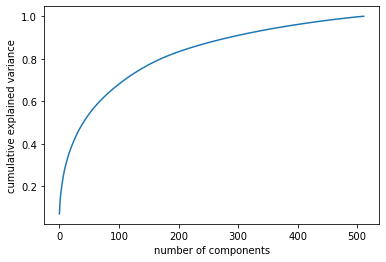

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# juiste PCA componentes zoeken van de grafiek
pca = PCA()
data_reduced = pca.fit_transform(train_hogs_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

TODO: model opbouwen en eventueel verbeteren. je kan normaal hogs gebruiken als x_train

In [16]:
# we namen als n_components 350
pca = PCA(n_components = 350)
# de getransformeerde data zijn onze features
x_train = pca.fit_transform(train_images_hogs)
y_train = df_train['general rating'].values

print(y_train)

[4.5       4.0184244 4.        ... 3.5       4.        4.       ]
